In [1]:
import datetime
import numpy as np
import pandas as pd
import xarray as xr
import astropy.units as u
import matplotlib.pyplot as plt
import matplotlib.gridspec as grd
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
#from evaluation_functions import ensemble_evaluation_functions as eef
#import sunspots.sunspots as sunspots
import re  #for dealing with non-numeric characters in a string of unknown length

import matplotlib as mpl
import os
import time

import huxt as H
import huxt_analysis as HA
import huxt_inputs as Hin

import scipy.interpolate
from scipy import integrate
from scipy.optimize import curve_fit

from sunpy.coordinates.sun import carrington_rotation_time
from sunpy.coordinates.sun import carrington_rotation_number

# ensemble functions
import huxt_ensemble_functions as hef 
import calibration_functions as cf

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def ICMElist(filepath = None):
    # -*- coding: utf-8 -*-
    """
    A script to read and process Ian Richardson's ICME list.

    Some pre-processing is required:
        Download the following webpage as a html file: 
            http://www.srl.caltech.edu/ACE/ASC/DATA/level3/icmetable2.htm
        Open in Excel, remove the year rows, delete last column (S) which is empty
        Cut out the data table only (delete header and footer)
        Save as a CSV.

    """
    
    if filepath is None:
        datapath =  system._setup_dirs_()['datapath']
        filepath = os.path.join(datapath,
                                'icmetable.csv')
    
    
    icmes=pd.read_csv(filepath,header=None)
    #delete the first row
    icmes.drop(icmes.index[0], inplace=True)
    icmes.index = range(len(icmes))
    
    for rownum in range(0,len(icmes)):
        for colnum in range(0,3):
            #convert the three date stamps
            datestr=icmes[colnum][rownum]
            year=int(datestr[:4])
            month=int(datestr[5:7])
            day=int(datestr[8:10])
            hour=int(datestr[11:13])
            minute=int(datestr[13:15])
            #icmes.set_value(rownum,colnum,datetime(year,month, day,hour,minute,0))
            icmes.at[rownum,colnum] = datetime.datetime(year,month, day,hour,minute,0)
            
        #tidy up the plasma properties
        for paramno in range(10,17):
            dv=str(icmes[paramno][rownum])
            if dv == '...' or dv == 'dg' or dv == 'nan':
                #icmes.set_value(rownum,paramno,np.nan)
                icmes.at[rownum,paramno] = np.nan
            else:
                #remove any remaining non-numeric characters
                dv=re.sub('[^0-9]','', dv)
                #icmes.set_value(rownum,paramno,float(dv))
                icmes.at[rownum,paramno] = float(dv)
        
    
    #chage teh column headings
    icmes=icmes.rename(columns = {0:'Shock_time',
                                  1:'ICME_start',
                                  2:'ICME_end',
                                  10:'dV',
                                  11: 'V_mean',
                                  12:'V_max',
                                  13:'Bmag',
                                  14:'MCflag',
                                  15:'Dst',
                                  16:'V_transit'})
    return icmes

def compute_lead_time_stats(df):

    df_ = df.copy()
    
    # Calculating the statistics
    df_['mean'] = df_.mean(axis=1)
    df_['median'] = df_.median(axis=1)
    df_['min'] = df_.min(axis=1)
    df_['max'] = df_.max(axis=1)
    df_['lower_1_sigma'] = df_.apply(lambda row: np.percentile(row, 15.87), axis=1)
    df_['upper_1_sigma'] = df_.apply(lambda row: np.percentile(row, 84.13), axis=1)
    df_['lower_2_sigma'] = df_.apply(lambda row: np.percentile(row, 2.28), axis=1)
    df_['upper_2_sigma'] = df_.apply(lambda row: np.percentile(row, 97.72), axis=1)

    return df_

def date_from_ensemble_folder_name(fname):
    
    """
    extracts date from wsa filename

    Args:
        fname (string) : name of ensemble file set
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
    match = re.search(pattern, fname)
    year, month, day, hour = match.groups()
    date_string = f'{year}-{month}-{day}--{hour}'
    date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')

    return date_string, date_obj

In [3]:
def read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude,  year_str, start_date, end_date, observed_data):

    year_id = {'2023':'_2023', '2020':'_2020'} # awkward file string formating stuff which will be removed when I fix the file name consistency

    # get all ensemble netCDF file strings of specified parameters
    ensemble_directory_path = os.path.abspath(os.path.join(os.pardir,'data','ensembles'))
    ensemble_file_words = [f'ens_{int(sigma_latitude)}_{ensemble_size}_wsa{year_id[year_str]}'] # keywords to filter ensemble set directory
    ensemble_fname = hef.get_files_containing_words(ensemble_directory_path, ensemble_file_words)[0]
    all_files = os.listdir(os.path.abspath(os.path.join(os.pardir,'data','ensembles',ensemble_fname))) # list of all files inside ensemble directory
    dates = []
    filenames = []

    # creating list of filenames of ensemble files for reading in ensembles over a specfied date range
    for filename in all_files:

        #unpack ensemble datenum into an indexable datetime obj
        pattern = r'_(\d{4})(\d{2})(\d{2})(\d{2})'
        match = re.search(pattern, filename)
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        dates.append(datetime.datetime(int(year), int(month), int(day), int(hour)))

    # index ensemble filenames by date
    df_ens_filenames = pd.DataFrame({'file_string' : all_files}, index = dates)
    df_ens_filenames = df_ens_filenames.sort_index()

    # # specify date range of ensemble to load in
    # start_date = datetime.datetime(2023,1,1)
    # end_date = datetime.datetime(2024,1,1)

    date_range = pd.date_range(start_date, end_date, freq='D') # daily frequency

    # Finding closest indices
    indexer = df_ens_filenames.index.get_indexer(date_range, method='nearest')

    # Retrieving the closest rows
    closest_files = df_ens_filenames.iloc[indexer]

    # Dropping duplicates to keep only unique rows -- unlikely for any duplicates but just in case :/ 
    unique_files = closest_files[~closest_files.index.duplicated(keep='first')]

    # list of ensemble netCDF filenames within date_range
    fname_list = unique_files['file_string'].to_list()


    daily_ensemble_sets = []
    updated_data_chunks = []

    for fname in fname_list:
        date_string, date_obj = date_from_ensemble_folder_name(fname)
        random_seed = int(date_obj.strftime("%y%m%d%H%M"))

        # read in ensemble members and perturb longitudinally
        ensemble_members = hef.read_ens_cdf(date_string=date_string, sigma_latitude=sigma_latitude, ensemble_size=ensemble_size, coronal_model='wsa', year=year_str)
        lp_ens_members = hef.perturb_ensemble_longitudinally(ensemble_members=ensemble_members, sigma_longitude=sigma_longitude, 
                                                                ensemble_size=ensemble_size, random_seed=random_seed)

        observed_df = observed_data['V'][lp_ens_members[0].index[0]:lp_ens_members[0].index[-1]]
        resampled_ensemble_data = [hef.interpolate_and_resample(observed_data=observed_df, forecast_series=ens_mem) for ens_mem in lp_ens_members]

        resampled_ensembles_df = pd.DataFrame(np.stack(resampled_ensemble_data).T, index=observed_df.index, columns=[f'vsw_{i}' for i in range(ensemble_size)])
        resampled_ensembles_df['observation'] = observed_df

        #append to main storage list
        daily_ensemble_sets.append(resampled_ensembles_df)
        updated_data_chunks.append(observed_df)

    return daily_ensemble_sets

In [4]:
def generate_ensemble_statistics(ensemble_members):
    """
    computes ensemble statistics which characterise the ensemble spread per timestep. 
     - range (min/max)
     - ensemble median/mean
     - 1 sigma spread (upper/lower)
     - 2 sigma spread (upper/lower)

    Args:
        ensemble_members (dataFrame) : dataFrames containing HUXt ensemble runs (each column representing an ensemble member labelled 'vswXX')
    
    Returns:
        statistics_df (dataFrame) : timeseries of relevant ensemble statistics in each column
    """

    # Group by time 
    grouped_df = ensemble_members.filter(like='vsw')

    # Compute statistics
    min_values = grouped_df.min(axis=1)
    max_values = grouped_df.max(axis=1)
    median_values = grouped_df.median(axis=1)
    mean_values = grouped_df.mean(axis=1)
    lower_2s_percentile = grouped_df.quantile(0.14, axis=1)
    upper_2s_percentile = grouped_df.quantile(0.86, axis=1)
    lower_1s_percentile = grouped_df.quantile(0.34, axis=1)
    upper_1s_percentile = grouped_df.quantile(0.68, axis=1)

    # Combine statistics into a single dataframe
    statistics_df = pd.DataFrame({
        'min': min_values,
        'max': max_values,
        'median' : median_values,
        'mean' : mean_values,
        '1s_lower_percentile': lower_1s_percentile,
        '1s_upper_percentile': upper_1s_percentile,
        '2s_lower_percentile': lower_2s_percentile,
        '2s_upper_percentile': upper_2s_percentile
    })

    return statistics_df

In [5]:
# omni data directory
omni_data_dir = 'C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_calibration\\data\\OMNI\\Processed_omni\\'

# load the data into dataframe and index by datetime
omni_data = pd.read_hdf(omni_data_dir + 'omni_1hour.h5')
omni_data = omni_data.set_index('datetime')
#omni_data = omni_data.dropna(subset = ['V']) # Remove rows with NaN values

## Create verificaton dataset with ICMEs removed from the timeseries
df_ICME = ICMElist("C:\\Users\\ct832900\\Desktop\\Research_Code\\WSA_Calibration\\data\\icmetable.csv")
df_ICME = df_ICME.set_index('Shock_time')

# Create a list of ICME (start,end) times 
CME_flags = [*zip(df_ICME.loc['2020':'2023']['ICME_start'], df_ICME.loc['2020':'2023']['ICME_end'])]

# Loop through ICME timing list and remove observations within CME start/end crossing period.
df_temp = omni_data.copy()
for start_time, end_time in CME_flags:
    
    # Replace values with NaN for rows within the specified time period
    df_temp.loc[(df_temp.index >= start_time) & (df_temp.index <= end_time)] = np.nan

    # Remove from time_series 
    #df_filtered = df_temp[~((df_temp.index >= start_time) & (df_temp.index <= end_time))]
    #df_temp = df_filtered.copy()

df_filtered = df_temp.copy()  

c:\Users\ct832900\AppData\Local\miniconda3\envs\wsahuxt\lib\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [34]:
# ensemble parameters
ensemble_size = 100
sigma_latitude = 4 # degrees
sigma_longitude = 5 # degrees
year_str = '2020'

# specify date range of ensemble to load in
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2021,1,1)

daily_ensemble_sets = read_daily_ensemble_sets(ensemble_size, sigma_latitude, sigma_longitude, year_str, start_date, end_date, df_filtered)

### Generating a WSA ensemble

In [7]:
def get_files_containing_words(directory, keywords):
    """
    creates list of all file name strings containing desired keywords

    Args:
        directory (string) : directory where files are stored
        keywords (list): list of desired keywords
    Returns:
        filtered_files (list) : list of filtered file names with desired keywords
    """

    # Get the list of all files in the directory
    all_files = os.listdir(directory)
    
    # Filter files that contain any of the specified words
    filtered_files = [file for file in all_files if any(word in file for word in keywords)]
    
    return filtered_files


def wsa_date_from_string(file_string):

    """
    extracts date from wsa filename

    Args:
        file_string (string) : wsa model solution file name string
    Returns:
        date_string (string) : date string generated from info within file string format
        date_obj (datetime) : datetime object from file name
    """

    # Define regular expression patterns to extract the date from file string
    pattern = r'21.5rs_(\d{4})(\d{2})(\d{2})(\d{2})' # file string 1
    pattern2 = r'%2F(\d{4})%2F(\d{1,2})%2F(\d{1,2})%2F' # file string 2
    pattern3 = r'gong_(\d{4})(\d{2})(\d{2})(\d{2})' # file string 3
    pattern4 = r'(\d{4})(\d{2})(\d{2})(\d{2})(\d{1})4R000_gongz' #file string 4

    # Match patterns for different WSA file string formats
    match = re.search(pattern, file_string)
    match2 = re.search(pattern2, file_string)
    match3 = re.search(pattern3, file_string)
    match4 = re.search(pattern4, file_string)
    
    # Check each match to find correct format
    if match:
        year, month, day, hour = match.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    elif match2:
        year, month, day = match2.groups()
        date_string = f'{year}-{month}-{day}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d')
    elif match3:
        year, month, day, hour = match3.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    elif match4:
        year, month, day, hour, _ = match4.groups()
        date_string = f'{year}-{month}-{day}--{hour}'
        date_obj = datetime.datetime.strptime(date_string, '%Y-%m-%d--%H')
    else:
        print(f"No date found in the string: {file_string}")

    return date_string, date_obj

def earth_latitude_wsa(filename):

    """
    creates list of all file name strings containing desired keywords

    Args:
        filename (string) : wsa model solution file name
    Returns:
        E_lat (float) : average heliolatitude of Earth during timeframe of WSA solution in radians 
    """
        
    # HUXt model parameters
    dt_scale = 4
    r_min = 21.5 * u.solRad
    forecast_window = 27 * u.day

    # getting velocity profile and start time and cr longitude
    _, init_wsa_date = wsa_date_from_string(filename)
    cr, cr_lon_init = Hin.datetime2huxtinputs(pd.Timestamp(init_wsa_date))

    # Use the HUXt ephemeris data to get Earth lat over the CR
    dummymodel = H.HUXt(v_boundary=np.ones(128)*400*(u.km/u.s), simtime=forecast_window, dt_scale=dt_scale, cr_num=cr,
                        cr_lon_init=cr_lon_init, lon_out=0.0*u.deg, r_min = r_min)

    # Retrieve a bodies position at each model timestep:
    earth = dummymodel.get_observer('earth')

    # Get average Earth lat
    E_lat = np.nanmean(earth.lat_c)

    return E_lat


def interpolate_vmap(velocity_map, lats, longs):
    """
    Generates an interpolated solution of velocity map ready for sub-earth path extraction

    Args:
        velocity_map (2D array) : coronal model velocity map, shape (n x m)
        lats (array) : latitudinal coords along inner boundary, array of size n
        longs (array) : longitudinal coords along inner boundary, array of size m
    Returns:
        Int_2D_solution (object) : interpolation solution object
    """
    # Generate coordinate grid using n x m defined by length of lats and longs array
    #lat, long = np.mgrid[:len(lats), :len(longs)]

    long, lat = np.meshgrid(longs, lats)

    # This is an array with the shape 2,X --> formatted coordinate grid for interpolation
    X2D = np.array([long.flatten(), lat.flatten()]).T  

    # Run interpolation on velocity map
    Int_2D_solution = scipy.interpolate.LinearNDInterpolator(X2D, velocity_map.flatten())

    return Int_2D_solution

def gen_ensemble_perturbed_boundary_path(E_lat, longitudes, ensemble_size, sigma_latitude, random_seed):
    """
    creates an ensemble of perturbed sub earth paths,
    perturbation is a sinusoidal perturbation in latitude equivalent to rotation of coronal model source.

    Args:
        E_lat (float) : Earth's heliolatitude in radians
        longitudes (array) : longitudinal coords along boundary in radians
        ensemble_size (int) : number of ensemble members 
        sigma_latitude (float) : scale parameter which controls spread of perturbed inner-boundaries in radians
        random_seed (int) : random seed for perturbation generation
    Returns: 
    """

    rng = np.random.default_rng(random_seed) # initialise random number generator

    wave_numbers = np.ones(ensemble_size) # wavenumber set to 1
    phase_offsets = rng.uniform(0, 2*np.pi, size = ensemble_size) # phase set from uniform random distribution
    lat_deviations = rng.normal(loc = 0, scale = sigma_latitude, size = ensemble_size) # max deviation sourced from gaussian with sigma_lat width

    # Generate ensemble of paths
    perturbed_paths = []
    for theta_max, wave_no, phase_off in zip(lat_deviations, wave_numbers, phase_offsets):

        path = E_lat + theta_max * np.sin(wave_no * (longitudes) + phase_off)

        #cut off values above max lat range
        upper_mask = path > np.radians(89)
        lower_mask = path < -np.radians(89)

        # Flat cut-off
        path[upper_mask] = np.radians(89)
        path[lower_mask] = -np.radians(89)

        # # Loop around
        # path[upper_mask] = path[upper_mask] - np.radians(178)
        # path[lower_mask] = path[lower_mask] + np.radians(178)

        # # Periodic Boundary Conditions (Spherical geometry)
        # path[upper_mask] = path[upper_mask] +
        # path[lower_mask] = path[lower_mask] + np.radians(178)

        perturbed_paths.append(path)
 

    return perturbed_paths * u.rad

def extract_interpolated_velocity_boundary(interpolated_map_solution, boundary, longitudes):
    """
    generates velocity profile across longitudes along perturbed boundary from an interpolated coronal model solution

    Args:
        interpolated_map_solution (object) : interpolation solution object
        boundary (array) : perturbed latitudinal coordinates along inner boundary
        longitudes (array) : longitudinal coords along inner boundary
        
    Returns:
        velocity_boundary (array) : interpolated velocities across longitude (along the inner boundary)
    """

    velocity_boundary = interpolated_map_solution(longitudes, boundary)

    return velocity_boundary

In [35]:
daily_ensemble_sets[0]['vsw_0']

datetime
2020-01-01 12:00:00    576.054359
2020-01-01 13:00:00    574.080268
2020-01-01 14:00:00    571.858073
2020-01-01 15:00:00    569.496592
2020-01-01 16:00:00    567.082780
                          ...    
2020-01-28 07:00:00    551.539854
2020-01-28 08:00:00    555.671444
2020-01-28 09:00:00    561.056542
2020-01-28 10:00:00    567.786268
2020-01-28 11:00:00    575.951742
Name: vsw_0, Length: 648, dtype: float64

vel_202001021214R000_gongz.fits
('2020-01-02--12', datetime.datetime(2020, 1, 2, 12, 0))


C:\Users\ct832900\AppData\Local\Temp\ipykernel_16516\2269503877.py:102: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3_lab, rotation =30)


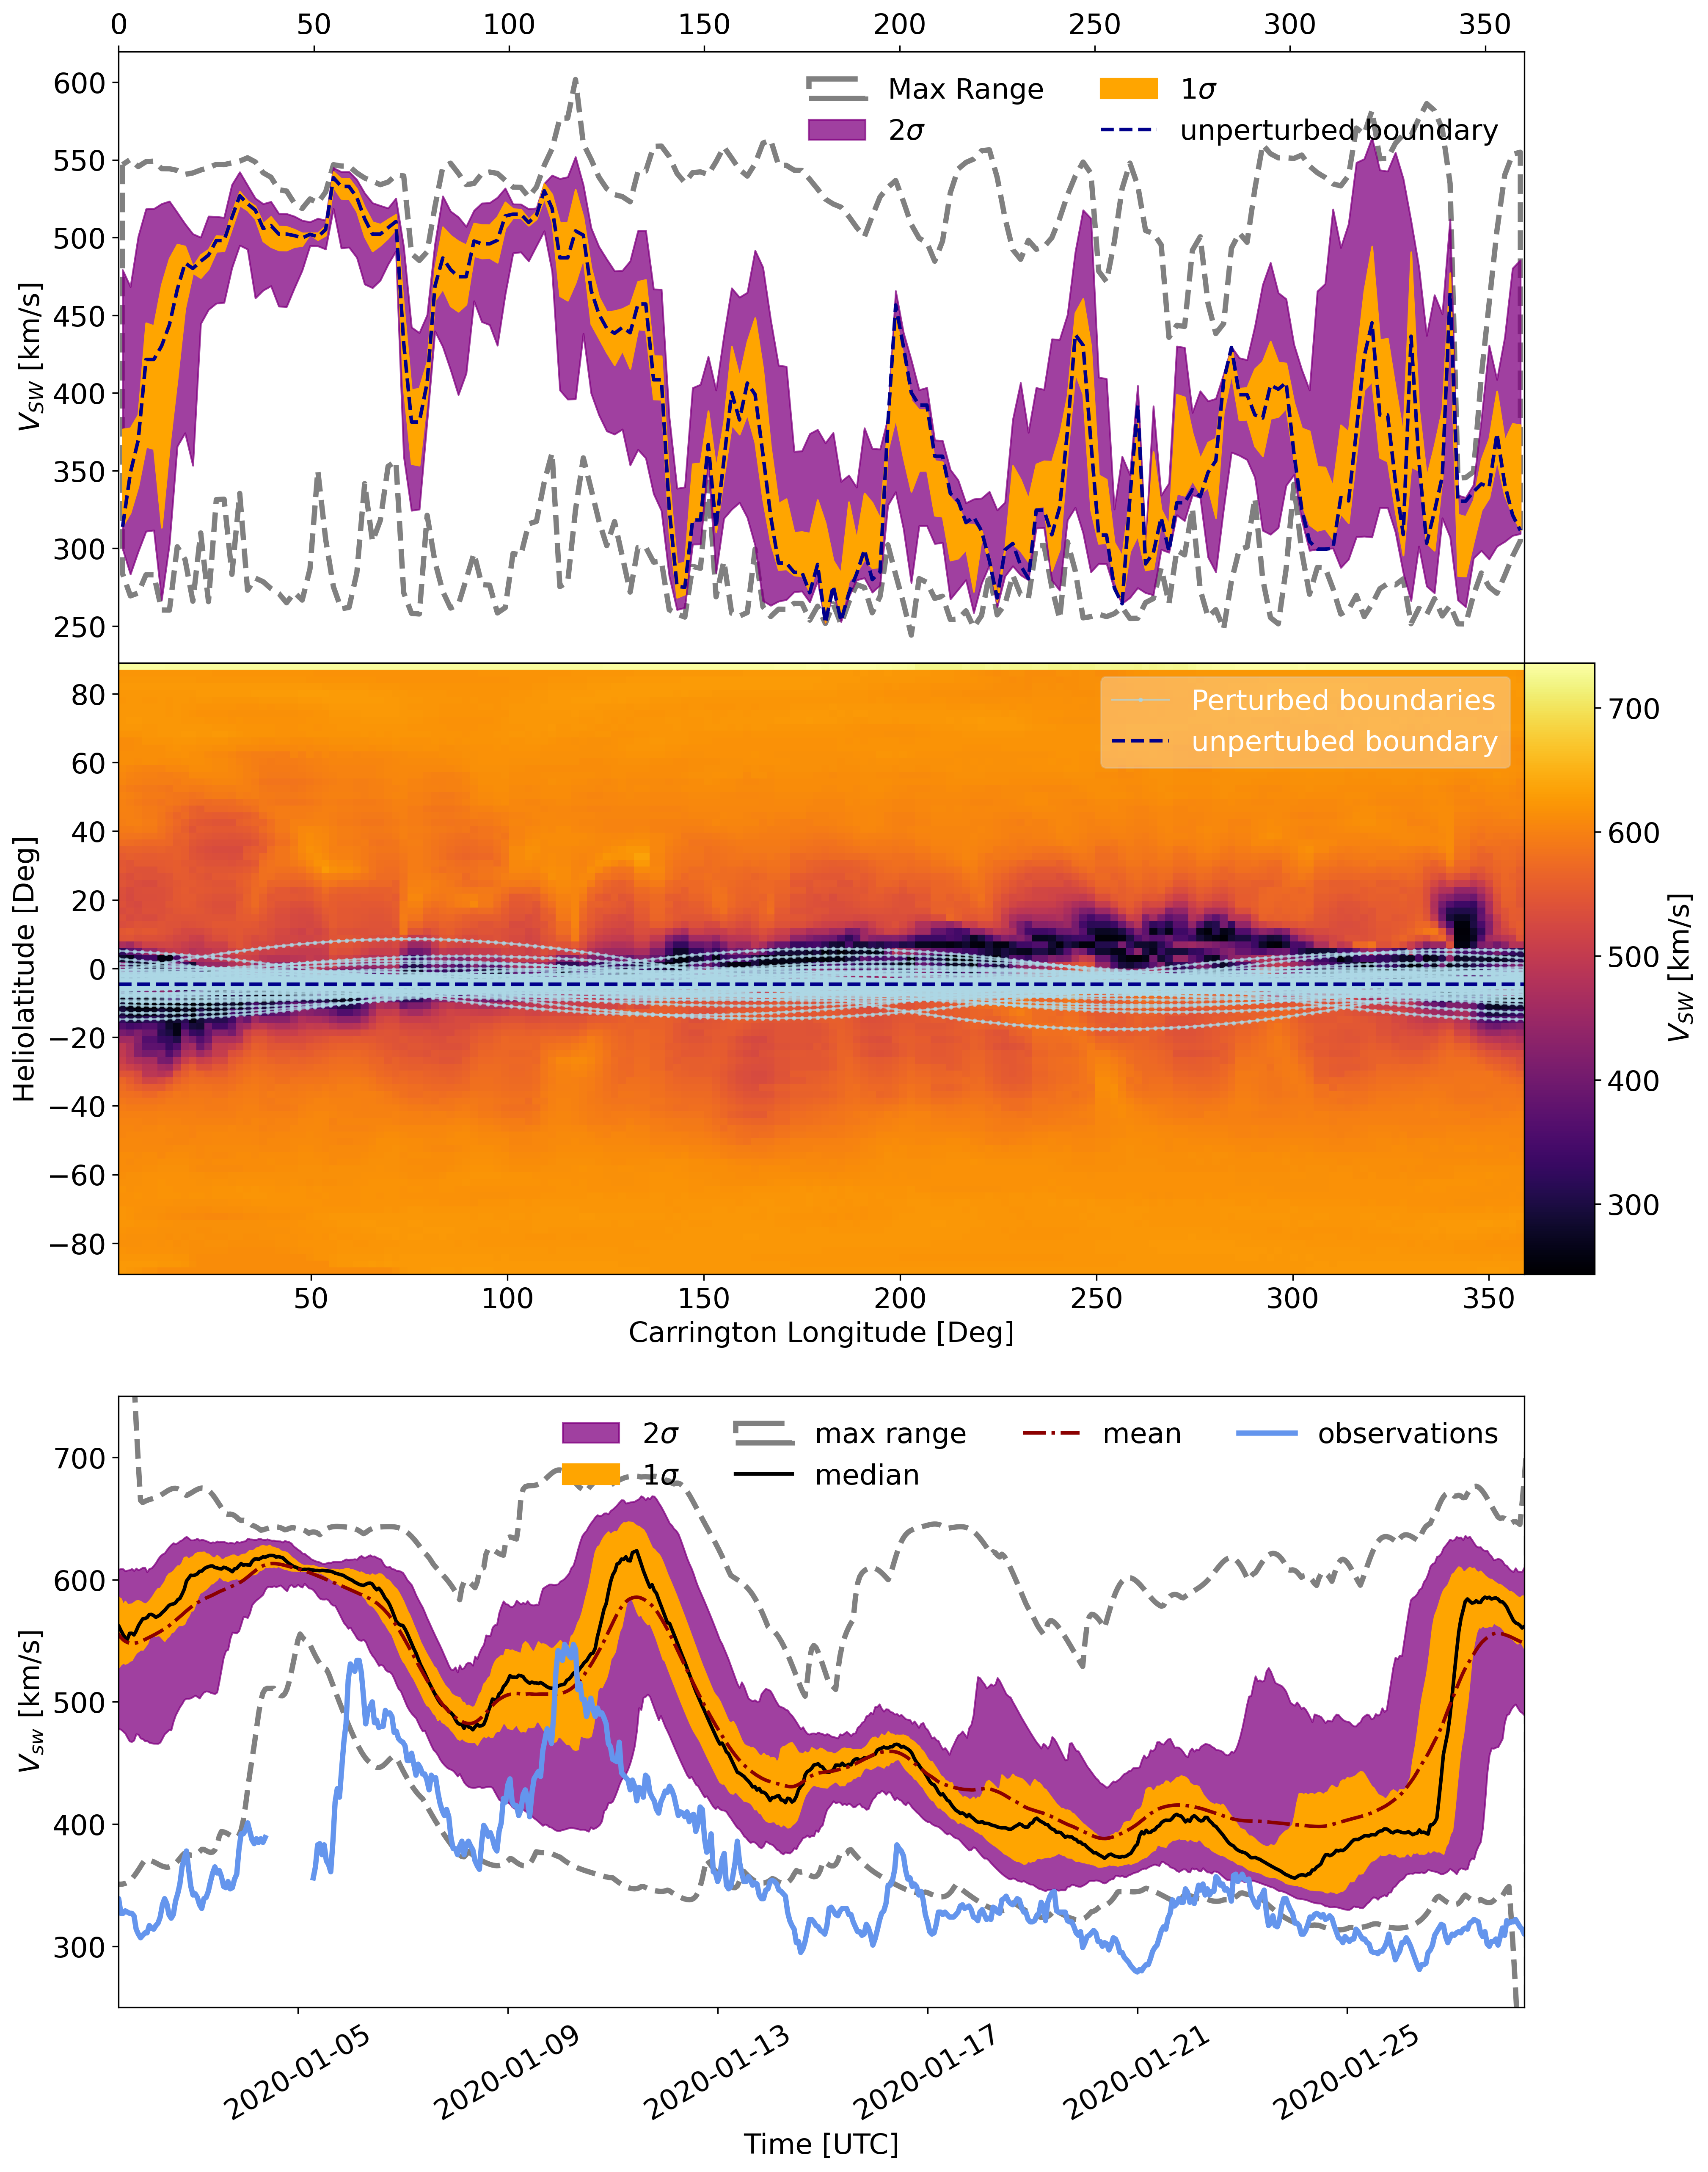

In [38]:
sigma_latitude = 4
ensemble_size = 100
# get all WSA files
directory_path = H._setup_dirs_()['boundary_conditions']
wsa_file_words = ['_gongz'] # keywords to filter for in coronal model file directory

# create wsa filepaths
wsa_fnames = get_files_containing_words(directory_path, wsa_file_words)
wsafilepaths = [os.path.join(directory_path, fname) for fname in wsa_fnames]

wsa_index = 1

WSA_vr_map, WSA_vr_longs, WSA_vr_lats, WSA_br_map, WSA_br_lats, WSA_br_longs, WSA_cr = Hin.get_WSA_maps(wsafilepaths[wsa_index])

print(wsa_fnames[wsa_index])
print(hef.wsa_date_from_string(wsa_fnames[wsa_index]))


# deaccelerate the WSA map from 1-AU calibrated speeds to expected 21.5 rS values
vr_map_deacc = WSA_vr_map.copy()
for nlat in range(1, len(WSA_vr_lats)):
    vr_map_deacc[nlat, :], lon_temp = Hin.map_v_inwards(WSA_vr_map[nlat, :], 215 * u.solRad, WSA_vr_longs, 21.5 * u.solRad)

INT = interpolate_vmap(vr_map_deacc.value, WSA_vr_lats.value, WSA_vr_longs.value)
E_lat = earth_latitude_wsa(filename = wsa_fnames[wsa_index]) 

perturbed_boundary_paths = gen_ensemble_perturbed_boundary_path(E_lat = E_lat.value, longitudes=WSA_vr_longs.value, 
                                                           ensemble_size = ensemble_size, sigma_latitude = np.radians(sigma_latitude), random_seed = 113567)

velocity_boundaries = [extract_interpolated_velocity_boundary(interpolated_map_solution=INT, boundary=boundary.value, longitudes=WSA_vr_longs.value) 
                       for boundary in perturbed_boundary_paths]

##### PLOTTING ######

fig = plt.figure(figsize = (15,20), dpi=300)

gs = grd.GridSpec(4, 2, height_ratios=[5,5,1,5], width_ratios=[10,0.5], wspace=0.0, hspace=0.0)

## plotting the WSA map with velocity boundaries
ax1 = plt.subplot(gs[2])
im = ax1.imshow(vr_map_deacc.value, cmap = 'inferno', aspect = 'auto',
           extent = [WSA_vr_longs[0].to(u.deg).value, WSA_vr_longs[-1].to(u.deg).value,
                     WSA_vr_lats[0].to(u.deg).value,WSA_vr_lats[-1].to(u.deg).value])

#plot perturbed boundaries
for boundary in perturbed_boundary_paths:
    ax1.plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'lightblue', lw = 1, alpha = 0.7, marker = '.', markersize = 3)

ax1.plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'lightblue', lw = 1, alpha = 0.7, marker = '.', markersize = 3, 
             label = 'Perturbed boundaries')

#axes[1].plot(WSA_vr_longs.to(u.deg).value, boundary.to(u.deg).value, color = 'blue', lw = 1, alpha = 0.5)
ax1.axhline(E_lat.to(u.deg).value, color = 'darkblue', linestyle = '--', label = r'unpertubed boundary', lw=2)


cbax = plt.subplot(gs[3])
cb = plt.colorbar(im, cax = cbax, label = r'$V_{SW}$ [km/s]', orientation = 'vertical', aspect = 30)#, location = 'bottom')
ax1.set_xlabel('Carrington Longitude [Deg]')
ax1.set_ylabel('Heliolatitude [Deg]')

ax1.legend(framealpha = 0.3, labelcolor = 'white')

### plotting ensemble of inner boundaries
ax2 = plt.subplot(gs[0])
ax2.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax2.fill_between(WSA_vr_longs.to(u.deg).value, np.min(velocity_boundaries, axis = 0), np.max(velocity_boundaries, axis = 0), 
                     linestyle = '--', color = 'grey', facecolor = 'None', label = 'Max Range', lw=3)

ax2.fill_between(WSA_vr_longs.to(u.deg).value, np.percentile(velocity_boundaries,13.6, axis = 0), np.percentile(velocity_boundaries, (100-13.6), axis = 0),
                     edgecolor = 'None', label = r'2$\sigma$', color = 'purple', alpha=0.75)
ax2.fill_between(WSA_vr_longs.to(u.deg).value, np.percentile(velocity_boundaries,34, axis = 0), np.percentile(velocity_boundaries, 68, axis = 0),
                     edgecolor = 'None', label = r'1$\sigma$', color = 'orange')


ax2.plot(WSA_vr_longs.to(u.deg).value, INT(WSA_vr_longs.value, np.ones(180)*E_lat.value), 
             color = 'darkblue', linestyle = '--', label = r'unperturbed boundary', lw=2)
ax2.set_ylabel(r'$V_{SW}$ [km/s]')

#ax2.set_title('Carrington Longitude [deg]', fontsize=15)
ax2.legend(frameon = False, ncols = 2)
ax2.set_xlim(0,360)

ax3 = plt.subplot(gs[6])

daily_index = 0
statistics_df = generate_ensemble_statistics(daily_ensemble_sets[daily_index])

ax3.fill_between(statistics_df.index, statistics_df['2s_lower_percentile'], statistics_df['2s_upper_percentile'], label = r'2$\sigma$', color = 'purple', alpha=0.75 )
ax3.fill_between(statistics_df.index, statistics_df['1s_lower_percentile'], statistics_df['1s_upper_percentile'], label = r'1$\sigma$', color = 'orange')
ax3.fill_between(statistics_df.index[1:-1], statistics_df['min'][1:-1], statistics_df['max'][1:-1], facecolor = 'none', edgecolor = 'grey', linestyle = '--', label = 'max range', lw=3 )
ax3.plot(statistics_df.index, statistics_df['median'], color = 'black', label = 'median', lw =2)
ax3.plot(statistics_df.index, statistics_df['mean'], color = 'darkred', linestyle = '-.', label = 'mean', lw=2)

ax3.plot(daily_ensemble_sets[daily_index]['observation'], color='cornflowerblue', label = 'observations', lw=3)
ax3.set_ylim(250,750)
ax3.set_xlim(daily_ensemble_sets[daily_index].index[2], daily_ensemble_sets[daily_index].index[-3])

ax3.set_xlabel('Time [UTC]')
ax3.set_ylabel(r'$V_{sw}$ [km/s]')
ax3.legend(frameon=False, ncols=4)
ax3_lab = ax3.get_xticklabels()
ax3.set_xticklabels(ax3_lab, rotation =30)


filename = "wsa_ensemble_pipeline.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

#plt.gcf().autofmt_xdate()
#plt.tight_layout()
plt.show()

### Rank Histogram Pipeline

In [40]:
# Compute ensemble ranks for each enesmble time step and daily ensemble set

for j, df_ in enumerate(daily_ensemble_sets):
    ranks = []
    for i in range(len(df_)):
        row = df_.iloc[i]

        if np.isnan(row['observation']) == True:
            rank = np.nan
        else:
            rank = np.sum(row.filter(like='vsw').to_numpy() > row['observation'])
        ranks.append(rank)

    df_['rank'] = ranks


C:\Users\ct832900\AppData\Local\Temp\ipykernel_16516\2019861716.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=10)
C:\Users\ct832900\AppData\Local\Temp\ipykernel_16516\2019861716.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=10)


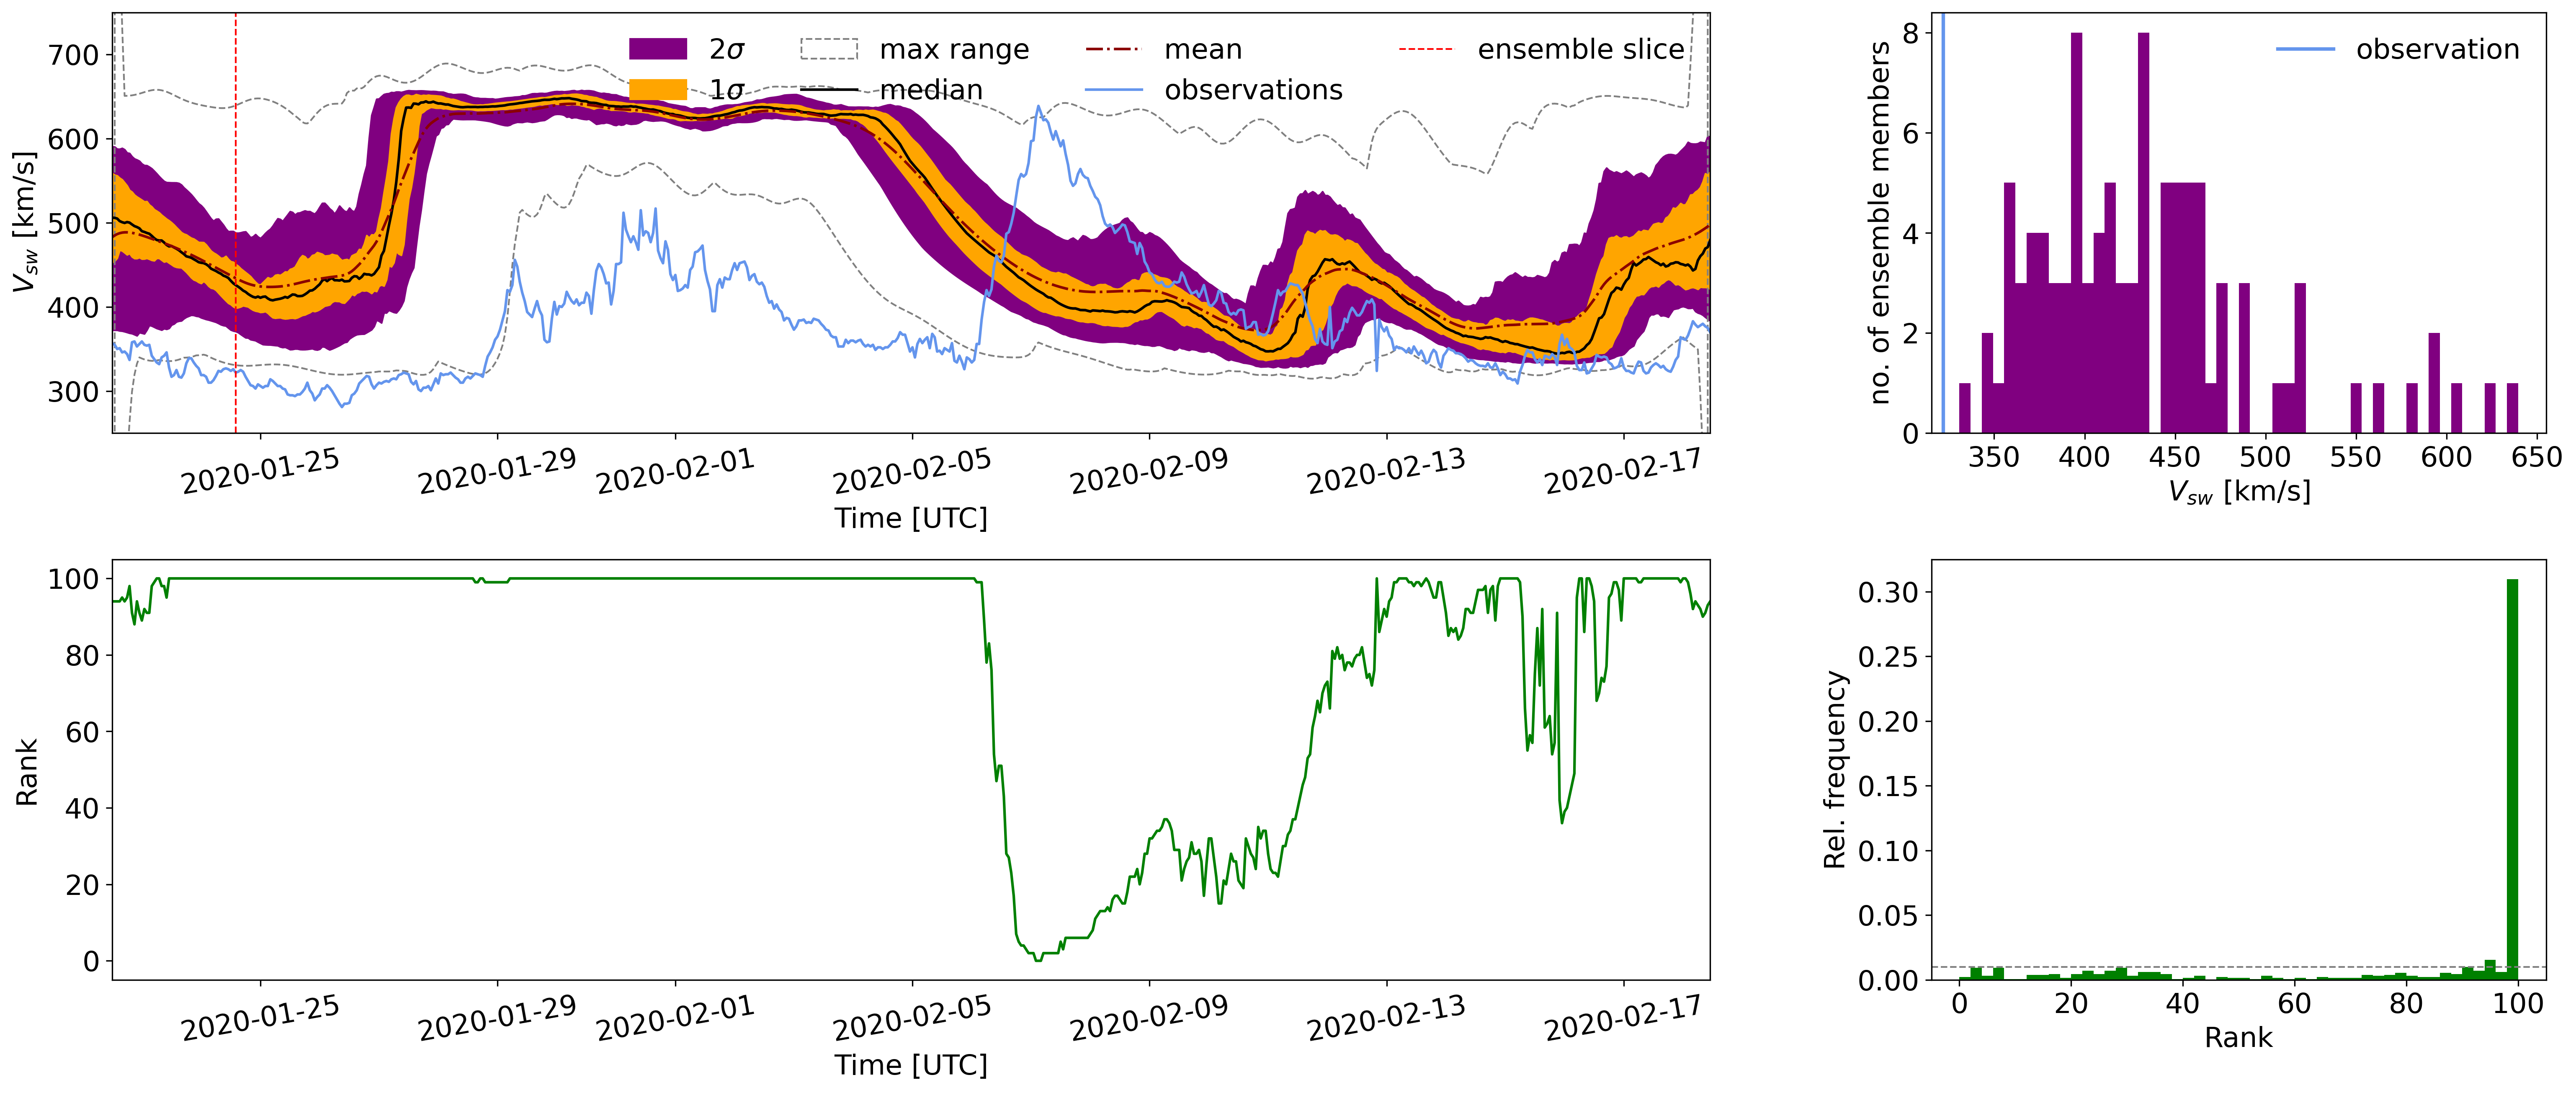

In [44]:
daily_index = 21
time_index = 50

statistics_df = generate_ensemble_statistics(daily_ensemble_sets[daily_index])

fig = plt.figure(figsize = (25,10),dpi=300)

gs = grd.GridSpec(2, 2, height_ratios=[5,5], width_ratios=[13,5], wspace=0.2, hspace=0.3)

ax = plt.subplot(gs[0])

ax.fill_between(statistics_df.index, statistics_df['2s_lower_percentile'], statistics_df['2s_upper_percentile'], label = r'2$\sigma$', color = 'purple' )
ax.fill_between(statistics_df.index, statistics_df['1s_lower_percentile'], statistics_df['1s_upper_percentile'], label = r'1$\sigma$', color = 'orange')
ax.fill_between(statistics_df.index[1:-1], statistics_df['min'][1:-1], statistics_df['max'][1:-1], facecolor = 'none', edgecolor = 'grey', linestyle = '--', label = 'max range' )
ax.plot(statistics_df.index, statistics_df['median'], color = 'black', label = 'median')
ax.plot(statistics_df.index, statistics_df['mean'], color = 'darkred', linestyle = '-.', label = 'mean')

ax.plot(daily_ensemble_sets[daily_index]['observation'], color='cornflowerblue', label = 'observations')
ax.axvline(daily_ensemble_sets[daily_index].index[time_index], color = 'red', lw=1, linestyle='--', label='ensemble slice')
ax.set_ylim(250,750)
ax.set_xlim(daily_ensemble_sets[daily_index].index[0], daily_ensemble_sets[daily_index].index[-1])
ax.set_xticklabels(ax.get_xticklabels(), rotation=10)

ax.set_xlabel('Time [UTC]')
ax.set_ylabel(r'$V_{sw}$ [km/s]')
ax.legend(frameon=False, ncols=4)

ax1 = plt.subplot(gs[1])
ax1.hist(daily_ensemble_sets[daily_index].iloc[time_index].filter(like='vsw'), color='purple', bins=50)
ax1.axvline(daily_ensemble_sets[daily_index].iloc[time_index]['observation'], color = 'cornflowerblue', lw=2, linestyle='-', label = 'observation')
ax1.legend(frameon=False)
ax1.set_ylabel('no. of ensemble members')
ax1.set_xlabel(r'$V_{sw}$ [km/s]')

ax2 = plt.subplot(gs[2])
ax2.plot(daily_ensemble_sets[daily_index]['rank'], color='green')
ax2.set_ylabel('Rank')
ax2.set_xlabel('Time [UTC]')
ax2.set_xlim(daily_ensemble_sets[daily_index].index[0], daily_ensemble_sets[daily_index].index[-1])
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=10)

ax3 = plt.subplot(gs[3])
ax3.hist(daily_ensemble_sets[daily_index]['rank'], color='green', density=True, bins=50)
ax3.set_ylabel('Rel. frequency')
ax3.set_xlabel('Rank')
ax3.axhline(1/ensemble_size, lw=1, color='gray', linestyle = '--')


filename = "rank_histogram_series.pdf"
fpath = f"C:\\Users\\ct832900\\OneDrive - University of Reading\\WSA calibration paper\\figures_01\\{filename}"
#plt.savefig(fpath, format = 'pdf', dpi = 300, bbox_inches='tight')

plt.show()